## Exercise: Heat diffusion on CPUs and GPU

**NOTE: This notebook should be run with 2 Julia threads and a GPU must be available!**

In [2]:
using CUDA
using Base.Threads
using ThreadPinning
pinthreads(:affinitymask)

@assert Threads.nthreads() > 1
@assert CUDA.functional()

![](../imgs/heat_diffusion_animation.gif)

## The heat equation
We consider the heat equation, a partial differential equation (PDE) describing the diffusion of heat over time. The PDE reads

$$ \dfrac{\partial T}{\partial t} = \alpha \left( \dfrac{\partial^2 T}{\partial x^2} + \dfrac{\partial^2 T}{\partial y^2} \right), $$

where the temperature $T = T(x,y,t)$ is a function of space ($x,y$) and time ($t$) and $\alpha$ is a scaling coefficient. Specifically, we'll consider a simple two-dimensional square geometry. As the initial condition - the starting distribution of temperature across the geometry - we choose a ["Gaussian"](https://en.wikipedia.org/wiki/Gaussian_function#:~:text=In%20mathematics%2C%20a%20Gaussian%20function,characteristic%20symmetric%20%22bell%20curve%22%20shape) positioned in the center.

#### Numerical solver
1) We discretize space (`dx`, `dy`) and time (`dt`) and evaluate everything on a grid.
2) We use the basic [finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to compute derivatives on the grid, e.g.
$$
\dfrac{\partial T}{\partial x}(x_i) \approx \dfrac{f(x_{i+1}) - f(x_i)}{\Delta x} 
$$
3) We use a two-step process:
    a) Compute the first-order spatial derivates.
    b) Then, update the temperature field (Euler time integration).
$$ 
\begin{align}
\partial x &= \dfrac{\Delta T}{\Delta x} \\
\partial y &= \dfrac{\Delta T}{\Delta y} \\
\Delta T &= \alpha\Delta t \left( \dfrac{\Delta (\partial x)}{\Delta x} + \dfrac{(\Delta \partial y)}{\Delta y} \right)
\end{align}
$$

Note that the derivatives give our numerical solver the character of a [stencil](https://en.wikipedia.org/wiki/Iterative_Stencil_Loops). **Stencils are typically memory bound**, that is, data transfer is dominating over FLOPs and consequently performance is limited by the rate at which memory is transferred between memory and the arithmetic units. For this reason we will measure the performance in terms of an **effective memory bandwidth**.

## Preparation

The following code is setup code (initializing parameters and arrays etc.) that you don't have to modify.

In [3]:
# ---- NO MODIFICATIONS HERE ----
using Printf

Base.@kwdef struct Parameters
    Δ::Float64
    Δt::Float64
    ngrid::Int64
end

function preparation(; ngrid=2^10, kwargs...)
    L = 10.0 # domain length
    Δ = L / ngrid # domain discretization
    Δt = Δ^2 / 4.1 # time discretization
    pts = range(start=Δ / 2, stop=L - Δ / 2, length=ngrid)
    p = Parameters(; Δt, Δ, ngrid)
    
    # temperature field - initial condition
    T = exp.(.-(pts .- L ./ 2.0) .^ 2 .- (pts .- L ./ 2.0)' .^ 2)

    # partial derivatives (preallocation)
    ∂x = zeros(ngrid - 1, ngrid - 2)
    ∂y = zeros(ngrid - 2, ngrid - 1)
    return T, ∂x, ∂y, p
end

function analysis_and_printing(elapsed_time, p; timesteps, verbose=true, kwargs...)
    membw_eff = 2 * p.ngrid^2 * sizeof(Float64) * timesteps * 1e-9 / elapsed_time
    if verbose
        @printf("\tmembw_eff = %1.2f GB/s, time = %1.1e s \n", round(membw_eff; digits=2), elapsed_time)
    end
    return nothing
end
# ---- NO MODIFICATIONS HERE ----

analysis_and_printing (generic function with 1 method)

## CPU - Sequential

Below you find a code snippet for the integration of the heat equation. 

**Task 1**

1) Implement the missing piece, that is, the update of the temperature field.

**Remarks**

* Don't update the temperature `T` at the boundary of the 2D square geometry (because the stencil would lead you out of bounds). That is, only update the inner part `T[2:(end - 1), 2:(end - 1)]`.

In [4]:
using Plots

function compute_first_order_loop!(∂x, ∂y, T, p)
    for j in 2:(p.ngrid-1)
        for i in 1:(p.ngrid-1)
            @inbounds ∂x[i, j-1] = (T[i+1, j] - T[i, j]) / p.Δ
        end
    end
    for j in 1:(p.ngrid-1)
        for i in 2:(p.ngrid-1)
            @inbounds ∂y[i-1, j] = (T[i, j+1] - T[i, j]) / p.Δ
        end
    end
    return nothing
end

function update_T_loop!(T, ∂x, ∂y, p)
    #
    # Task 1 TODO: Implement update of T with regular loops.
    #              See `compute_first_order_loop!` for inspiration.
    #
    for j in 2:(p.ngrid-1)
        for i in 2:(p.ngrid-1)
            @inbounds T[i, j] = T[i, j] + p.Δt *
                                          ((∂x[i, j-1] - ∂x[i-1, j-1]) / p.Δ +
                                           (∂y[i-1, j] - ∂y[i-1, j-1]) / p.Δ)
        end
    end
    return nothing
end

function heat_2D_animation(; ngrid=128, timesteps=400, kwargs...)
    T, ∂x, ∂y, p = preparation(; ngrid, kwargs...)
    
    # time loop
    @gif for it in 1:timesteps
        # -------- stencil kernel --------
        # first order derivatives
        compute_first_order_loop!(∂x, ∂y, T, p)
        # update T
        update_T_loop!(T, ∂x, ∂y, p)
        # --------------------------------
        
        # plotting
        pts = range(start=p.Δ / 2, stop=10.0 - p.Δ / 2, length=p.ngrid)
        heatmap(pts, pts, T', xlabel="x", ylabel="y", title="Heat Diffusion, i=$it", clims=(0.,1.))
    end every 5
end

heat_2D_animation (generic function with 1 method)

┌ Info: Saved animation to /tmp/jl_uzw3cZUfEJ.gif
└ @ Plots /shared/training/ws/sca50297-jlhpc/.julia/packages/Plots/du2dt/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_uzw3cZUfEJ.gif")
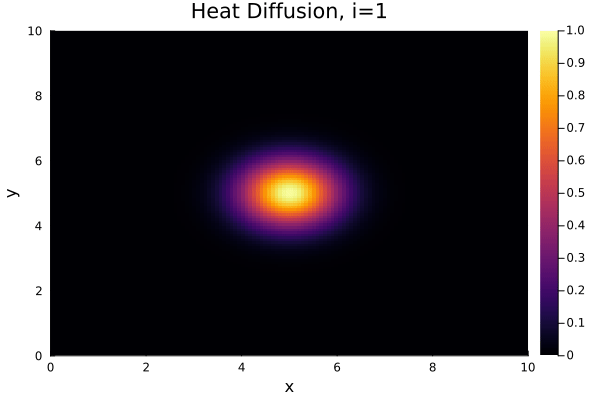

In [5]:
heat_2D_animation()

### Performance (without animation)
Let's get rid of the animation and measure the performance of our implementation.

In [6]:
function heat_2D(; timesteps=400, kwargs...)   
    T, ∂x, ∂y, p = preparation(; kwargs...)

    # time loop
    elapsed_time = @elapsed for _ in 1:timesteps
        # -------- stencil kernel --------
        # first order derivatives
        compute_first_order_loop!(∂x, ∂y, T, p)
        # update T
        update_T_loop!(T, ∂x, ∂y, p)
        # --------------------------------
    end
    
    analysis_and_printing(elapsed_time, p; timesteps, kwargs...)
end

heat_2D (generic function with 1 method)

In [7]:
heat_2D()

	membw_eff = 1.94 GB/s, time = 3.5e+00 s 


## CPU - Multithreaded
Let's multithread our stencil computation.

**Task 2**

1) Implement the missing piece, that is, the update of the temperature field via a multithreaded loop.

**Remarks**

* To respect column-major order (memory layout), the y-loop should be the outer loop and the x-loop the inner one.
* Use `@threads :static for ...` for parallelization.

In [8]:
function compute_first_order_loop_mt!(∂x, ∂y, T, p)
    @threads :static for j in 2:(p.ngrid-1)
        for i in 1:(p.ngrid-1)
            @inbounds ∂x[i, j-1] = (T[i+1, j] - T[i, j]) / p.Δ
        end
    end
    @threads :static for j in 1:(p.ngrid-1)
        for i in 2:(p.ngrid-1)
            @inbounds ∂y[i-1, j] = (T[i, j+1] - T[i, j]) / p.Δ
        end
    end
    return nothing
end

function update_T_loop_mt!(T, ∂x, ∂y, p)
    #
    # Task 2 TODO: Implement update of T via multithreaded loops.
    #              See `compute_first_order_loop_mt!` for inspiration.
    #
    @threads :static for j in 2:(p.ngrid-1)
        for i in 2:(p.ngrid-1)
            @inbounds T[i, j] = T[i, j] + p.Δt *
                                          ((∂x[i, j-1] - ∂x[i-1, j-1]) / p.Δ +
                                           (∂y[i-1, j] - ∂y[i-1, j-1]) / p.Δ)
        end
    end
    return nothing
end

function heat_2D_loop_multithreaded(; timesteps=400, kwargs...)   
    T, ∂x, ∂y, p = preparation(; kwargs...)

    # time loop
    elapsed_time = @elapsed for _ in 1:timesteps
        # -------- stencil kernel --------
        # first order derivatives
        compute_first_order_loop_mt!(∂x, ∂y, T, p)
        # update T
        update_T_loop_mt!(T, ∂x, ∂y, p)
        # --------------------------------
    end
    
    analysis_and_printing(elapsed_time, p; timesteps, kwargs...)
end

heat_2D_loop_multithreaded (generic function with 1 method)

In [9]:
println("CPU - Multithreaded:")
heat_2D_loop_multithreaded();

CPU - Multithreaded:
	membw_eff = 3.25 GB/s, time = 2.1e+00 s 


## GPU - CUDA Kernels
Finally, we want to transform our loop implementations of `compute_first_order_loop_mt!` and `update_T_mt!` above into CUDA kernels. To that end, we simply replace the (multithreaded) `for`-loops by `if`-conditions that make sure that the indices stay within the bounds of the arrays. When the kernel is later spawned with `@cuda`, different GPU-threads will run our kernel function with different indices and thus realize the full update.

**Task 3**

1) Move the arrays `T`, `∂x`, and `∂y` to the GPU (before the `# time loop`).
2) Implement the update of the temperature field as a CUDA kernel.
3) At the marked position, spawn the `update_T_gpu!` kernel with `@cuda` using `cublocks`-many blocks and `cuthreads`-many threads.

**Remarks**

* **Important:** For a fair comparison, we want to have `CuArray{Float64}` rather than `CuArray`, which defaults to `CuArray{Float32}`.
* You may take `compute_first_order_gpu!` as inspiration for 2).

In [10]:
function compute_first_order_gpu!(∂x, ∂y, T, p)
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x # thread ID, dimension x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y # thread ID, dimension y

    if ix <= p.ngrid - 1
        if 2 <= iy <= p.ngrid - 1
            ∂x[ix, iy - 1] = (T[ix + 1, iy] - T[ix, iy]) / p.Δ
        end
    end
    if 2 <= ix <= p.ngrid - 1
        if iy <= p.ngrid - 1
            ∂y[ix - 1, iy] = (T[ix, iy + 1] - T[ix, iy]) / p.Δ
        end
    end
    return nothing
end

function update_T_gpu!(T, ∂x, ∂y, p)
    #
    # Task 4 TODO: Implement the temperature update as a CUDA kernel.
    #              See `compute_first_order_gpu!` above for inspiration.
    #
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x # thread ID, dimension x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y # thread ID, dimension y

    if 2 <= ix <= p.ngrid - 1
        if 2 <= iy <= p.ngrid - 1
            T[ix, iy] = T[ix, iy] +
                        p.Δt * ((∂x[ix, iy - 1] - ∂x[ix - 1, iy - 1]) / p.Δ +
                              (∂y[ix - 1, iy] - ∂y[ix - 1, iy - 1]) / p.Δ)
        end
    end
    return nothing
end

function heat_2D_gpu_kernels(; timesteps=400, kwargs...)
    T, ∂x, ∂y, p = preparation(; kwargs...)
    T = CuArray(T)
    ∂x = CuArray(∂x)
    ∂y = CuArray(∂y)

    # launch configuration
    blockx, blocky = 32, 32
    gridx, gridy = p.ngrid ÷ 32, p.ngrid ÷ 32
    cuthreads = (blockx, blocky, 1)
    cublocks = (gridx, gridy, 1)

    # time loop
    elapsed_time = @elapsed for _ in 1:timesteps
        # -------- stencil kernel --------
        # first order derivatives
        CUDA.@sync @cuda blocks=cublocks threads=cuthreads compute_first_order_gpu!(∂x, ∂y, T, p)

        # update T
        #
        # Task 4 TODO: Spawn the `update_T_gpu!` kernel with `@cuda`.
        #
        CUDA.@sync @cuda blocks=cublocks threads=cuthreads update_T_gpu!(T, ∂x, ∂y, p)
        # --------------------------------
    end
    
    analysis_and_printing(elapsed_time, p; timesteps, kwargs...)
end

heat_2D_gpu_kernels (generic function with 1 method)

In [11]:
println("GPU - CUDA Kernels:")
heat_2D_gpu_kernels()
heat_2D_gpu_kernels()

GPU - CUDA Kernels:
	membw_eff = 0.31 GB/s, time = 2.2e+01 s 
	membw_eff = 106.15 GB/s, time = 6.3e-02 s 


## Performance Comparison

In [12]:
using BenchmarkTools

println("CPU - Sequential:")
@btime heat_2D() samples=2 evals=3;

println("\nCPU - Multithreaded:")
@btime heat_2D_loop_multithreaded() samples=2 evals=3;

println("\nGPU - CUDA Kernels:")
@btime heat_2D_gpu_kernels() samples=2 evals=3;

CPU - Sequential:
	membw_eff = 1.94 GB/s, time = 3.5e+00 s 
	membw_eff = 1.94 GB/s, time = 3.5e+00 s 
	membw_eff = 1.94 GB/s, time = 3.5e+00 s 
	membw_eff = 1.94 GB/s, time = 3.5e+00 s 
  3.518 s (50 allocations: 23.96 MiB)

CPU - Multithreaded:
	membw_eff = 13.81 GB/s, time = 4.9e-01 s 
	membw_eff = 11.18 GB/s, time = 6.0e-01 s 
	membw_eff = 14.34 GB/s, time = 4.7e-01 s 
	membw_eff = 13.96 GB/s, time = 4.8e-01 s 
	membw_eff = 11.06 GB/s, time = 6.1e-01 s 
	membw_eff = 13.98 GB/s, time = 4.8e-01 s 
	membw_eff = 13.81 GB/s, time = 4.9e-01 s 
  576.592 ms (49278 allocations: 29.22 MiB)

GPU - CUDA Kernels:
	membw_eff = 108.19 GB/s, time = 6.2e-02 s 
	membw_eff = 106.28 GB/s, time = 6.3e-02 s 
	membw_eff = 107.14 GB/s, time = 6.3e-02 s 
	membw_eff = 106.71 GB/s, time = 6.3e-02 s 
	membw_eff = 106.90 GB/s, time = 6.3e-02 s 
	membw_eff = 108.07 GB/s, time = 6.2e-02 s 
	membw_eff = 106.97 GB/s, time = 6.3e-02 s 
  126.452 ms (30498 allocations: 24.65 MiB)


## Bonus A

* Write a "vectorized" version that doesn't use loops but operates on the `T`, `∂x`, and `∂y` arrays via broadcasting.
    * Finite difference method: You can use `diff(A, dims=1) ./ dx` to compute the partial derivative of a field `A` in the x-direction (`dims=2` corresponds to y-direction).
* Don't update the temperature `T` at the boundary of the 2D square geometry. That is, only update the inner part `T[2:(end - 1), 2:(end - 1)]`.
* Compare a CPU and GPU version where the arrays are `Array`s or `CuArray`s respectively.
* How much slower are these variants compared to the loop/kernel versions above?

## Bonus B

* Use [KernelAbstractions.jl](https://github.com/JuliaGPU/KernelAbstractions.jl) to write a backend agnostic variant that can run on both CPU and GPU.